In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt #opdrachtprompt pip install netCDF4
from netCDF4 import Dataset
import pandas as pd
from pandas import *
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as feature
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#1D5365", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

import regionmask
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape, mapping
from scipy.stats import norm
from scipy.stats import skew
import matplotlib.mlab as mlab
from scipy.stats import genextreme as gen

In [2]:
#Latex lay-out graphs
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

## Mask area 

Functions are given to read from a shapefile (polygons, as well as key values) written by H.C. Winsemius 

In [3]:
def fiona_feats(fn):
    """
    turn shapes in shapefile into a list of GeoJSON strings, and return values in key in separate list
    """
    ds = fiona.open(fn)
    feats = [feat['geometry'] for feat in ds]
    ds.close()
    return feats
    
def feats2json(feats):
    """
    Change list of shapes into GeoJSON strings
    """
    return [str(shape(feat)) for feat in feats]

def fiona_keyvalue(fn, key):
    """
    Return a list of values belonging to provided key in shapefile
    """
    ds = fiona.open(fn)
    return [feat['properties'][key] for feat in ds]

def cut_xarray(ds, var, extent):
    """
    Make a geographically bounded cut out of a specific variable in an xarray dataset
    Input:
        ds: xarray dataset
        var: - string variable name
        extent: tuple containing extent as (xmin, xmax, ymin, ymax)
    """
    ds_var = ds[var]
    xmin, xmax, ymin, ymax = extent
    return ds_var.sel(lat=slice(ymax, ymin), lon=slice(xmin, xmax), time=slice('2000-01-01', '2018-12-31'))

def prepare_mask(fn, names_key, abbrev_key):
    """
    Read in a polygon shapefile (or any other fiona compatible file)
    and returns a regionmask object
    Input:
        fn: - string filename
        names_key: - shapefile attribute with names of polygons
        abbrev_key: - shapefile attribute with abbreviated names of polygons (can be the same as names_key)
    Returns:
        regionmask object
    """
    pols = fiona_feats(fn)
    names = fiona_keyvalue(fn, names_key)
    numbers = range(len(names))  # make a list of numbers, one for each province starting from 0
    abbrevs = fiona_keyvalue(fn, abbrev_key)
    # turn shapefile into a regionmask object
    return regionmask.Regions_cls('Kenya', numbers, names, abbrevs, [shape(poly) for poly in pols])

def region_ts_from_ds(ds, mask, stepsize=100, return_as_df=False, unit_multiplier=86400):
    """
    Extracts an aggregated time series from a xarray ds using a polygon regionmask object
    Inputs:
        ds: xarray dataset (containing one variable)
        mask: polygon regionmask object
        stepsize=100: stepsize for which data should be retrieved. This retrieval only happens when data is returned as pandas dataframe
        return_as_df=False: if set to true, data is retrieved and stored in pandas dataframe, if false, it is provided as a xarray object
    """
    mask_grid = mask.mask(ds)  # convert polygon mask to grid mask
    ds_region = ds.groupby(mask_grid).mean('stacked_lat_lon')*unit_multiplier
    ids = np.unique(mask_grid.values)
    ids = list(np.array(ids[np.isfinite(ids)], dtype='int').flatten())
    names_select = np.array(mask.names)[ids]
    abbrev_select = np.array(mask.abbrevs)[ids]
    ds_region.coords['abbrevs'] = ('region', abbrev_select)
    ds_region.coords['names'] = ('region', names_select)
    ds_region.coords['ids'] = ('region', ids)
    if return_as_df:
        # retrieve all data from xarray ds and return as a pandas dataframe
        df = pd.DataFrame()
        # prepare the dataframe slice by slice (otherwise dask hits an I/O error for some reason)
        ts = 0
        while ts < len(ds_region):
            # this loop is needed because larger chunks give a I/O error with dask / xarray! In later versions this bug is likely to be resolved
            ts += stepsize
            print (ts)
            _df = ds_region.isel(time=slice(ts - stepsize, ts)).to_dataframe() # .drop([region, abbrevs, names]).to_dataframe()
            df = df.append(_df)
        return df
    else:
        return ds_region
        # leave the data as an xarray object (i.e. retrieval still needs to be done)


## Historical time series over masked area

Datasets used in this script are CHIRPS precipitation data, Standard Precipitation and Evaporation (SPEI) Data, NDVI GIMMS: 

Rainfall data CHIRPS: 
Conventions: CF-1.6
title: CHIRPS Version 2.0
history: created by Climate Hazards Group
version: Version 2.0
date_created: 2015-04-20
creator_name: Pete Peterson


Global 1-month SPEI, z-values, 0.5 degree 
Version: 2.5, 

Global dataset of the Standardized Precipitation-Evapotranspiration Index (SPEI) at the 1-month time scale. Using CRU TS 4.00 precipitation and potential evapotranspiration data. 

Url: http://sac.csic.es/spei

GIMMS NDVI from AVHRR Sensors (3rd Generation)
           1981-2013
           NASA/GIMMS/3GV0:

### Standard Precipitation and Evaporation Data

In [1]:
# inputs that are only needed once
extent = (35., 38., 5., 2.)

# loading shapefil into python
fn = r'C:\Users\MPanis\Documents\IARP\Kenya\QGIS\Data\KEN_Admin\ken_admbnda_adm0_iebc_20180607.shp'

names_key = 'ADM0_EN'
abbrev_key = 'ADM0_EN'

# first setup the mask
mask = prepare_mask(fn, names_key, abbrev_key)

#url = r'https://wci.earth2observe.eu/thredds/dodsC/jrc/mswep-rainf-daily-agg.nc'
var = 'spei'

#load dataset spei 1-monthly
ds = xr.open_dataset(r'C:\Users\MPanis\Documents\510 Documents\Python scripts\spei01.nc')
m = 1.
if 'latitude' in ds.dims:
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
#dsM = ds.resample(freq = 'M', dim='time', how='mean')
ds_var_KEN_SPEI = cut_xarray(ds, var, extent)

KENYA_SPEI = region_ts_from_ds(ds_var_KEN_SPEI, mask, stepsize=1, return_as_df=False, unit_multiplier=m)

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

KENYA_SPEI.plot()

plt.title('Standardised Precipitation and Evaporation Semi_Arid Areas')

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='')

#Drought periods Kenya in general
#Desintentar
#ax.axvspan("2009-08-01", "2010-03-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2010-04-01", "2010-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2011-03-01", "2011-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)#duration not known

#EMDAT
#ax.axvspan("2004-07-01", "2005-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2005-12-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2008-07-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2011-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2012-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2014-01-01", "2015-05-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2016-06-01", "2018-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)

NameError: name 'prepare_mask' is not defined

In [2]:
# inputs that are only needed once
extent = (35., 38., 5., 2.)
# loading shapefil into python
fn = r'C:\Users\MPanis\Documents\IARP\Kenya\QGIS\Data\KEN_Semiarid\KEN_Semiaid.shp'

names_key = 'ADM1_EN'
abbrev_key = 'ADM1_EN'

# first setup the mask
mask = prepare_mask(fn, names_key, abbrev_key)

#url = r'https://wci.earth2observe.eu/thredds/dodsC/jrc/mswep-rainf-daily-agg.nc'
var = 'spei'


ds = xr.open_dataset(r'C:\Users\MPanis\Documents\510 Documents\Python scripts\spei01.nc')
m = 1.
if 'latitude' in ds.dims:
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
#dsM = ds.resample(freq = 'M', dim='time', how='mean')
ds_var_SA_SPEI = cut_xarray(ds, var, extent)

KEN_SA_SPEI = region_ts_from_ds(ds_var_SA_SPEI, mask, stepsize=1, return_as_df=False, unit_multiplier=m)

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

KEN_SA_SPEI.plot()

plt.title('Standardised Precipitation and Evaporation Semi_Arid Areas')

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='Extremely dry')
plt.axhline(y=-2, color='k', linestyle='--', linewidth=0.5, label='Extremely dry')
plt.axhline(y=-1.5, color='k', linestyle='--', linewidth=0.5, label='Severely dry')
plt.axhline(y=-1.0, color='k', linestyle='--', linewidth=0.5, label='Moderately dry')
plt.axhline(y=-0.5, color='k', linestyle='--', linewidth=0.5, label='Mild dry')

#Drought periods Kenya in general
#Desintentar
#ax.axvspan("2009-08-01", "2010-03-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2010-04-01", "2010-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2011-03-01", "2011-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)#duration not known

#EMDAT
#ax.axvspan("2004-07-01", "2005-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2005-12-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2008-07-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2011-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2012-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2014-01-01", "2015-05-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2016-06-01", "2018-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)

ax.axvspan("2000-01-01", "2000-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
ax.axvspan("2004-01-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
ax.axvspan("2008-01-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)


NameError: name 'prepare_mask' is not defined

In [3]:
# inputs that are only needed once
extent = (35., 38., 5., 2.)
# loading shapefil into python
fn_A = r'C:\Users\MPanis\Documents\IARP\Kenya\QGIS\Data\KEN_Arid\KEN_Arid.shp'

names_key = 'ADM1_EN'
abbrev_key = 'ADM1_EN'

# first setup the mask
mask = prepare_mask(fn_A, names_key, abbrev_key)

#url = r'https://wci.earth2observe.eu/thredds/dodsC/jrc/mswep-rainf-daily-agg.nc'
var = 'spei'


ds = xr.open_dataset(r'C:\Users\MPanis\Documents\510 Documents\Python scripts\spei01.nc'
                      )
m = 1.
if 'latitude' in ds.dims:
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
#dsM = ds.resample(freq = 'M', dim='time', how='mean')
ds_var_A_SPEI = cut_xarray(ds, var, extent)



KEN_A_SPEI = region_ts_from_ds(ds_var_A_SPEI, mask, stepsize=1, return_as_df=False, unit_multiplier=m)


plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
KEN_A_SPEI.plot()

plt.title('Standardised Precipitation and Evaporation Arid Areas')

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='')

ax = plt.subplot(111)
#Drought periods Kenya in general
#ax.axvspan("2002-02-01", "2002-12-01",  color=sns.xkcd_rgb['grey'], alpha=0.5)

#Desintentar
#ax.axvspan("2009-08-01", "2010-03-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2010-04-01", "2010-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2011-03-01", "2011-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)#duration not known

#EMDAT
#ax.axvspan("2004-07-01", "2005-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2005-12-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2008-07-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2011-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2012-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2014-01-01", "2015-05-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2016-06-01", "2018-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)



NameError: name 'prepare_mask' is not defined

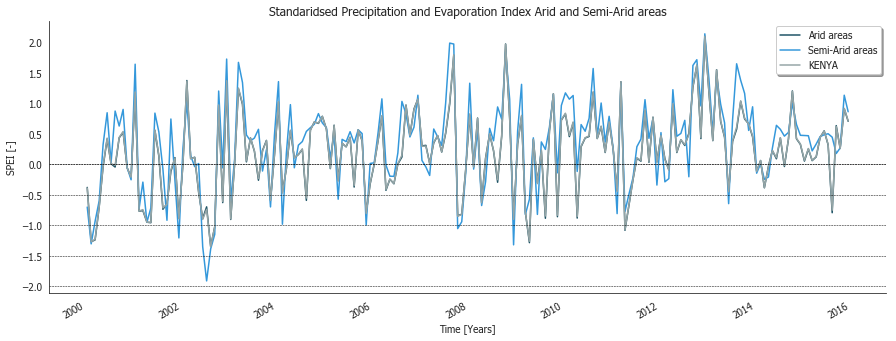

In [7]:
plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Plotted data
KEN_A_SPEI.plot(label='Arid areas')
KEN_SA_SPEI.plot(label='Semi-Arid areas')
KENYA_SPEI.plot(label='KENYA')

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='')

#Layout plot
plt.legend(loc='best',fancybox=True, shadow=True)
plt.ylabel('SPEI [-]')
plt.xlabel('Time [Years]')

plt.title('Standaridsed Precipitation and Evaporation Index Arid and Semi-Arid areas')

#Desintentar
#ax.axvspan("2009-08-01", "2010-03-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2010-04-01", "2010-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2011-03-01", "2011-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)#duration not known

#EMDAT
#ax.axvspan("2004-07-01", "2005-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2005-12-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2008-07-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2011-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2012-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2014-01-01", "2015-05-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2016-06-01", "2018-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='Extremely dry')
plt.axhline(y=-2, color='k', linestyle='--', linewidth=0.5, label='Extremely dry')
plt.axhline(y=-1.5, color='k', linestyle='--', linewidth=0.5, label='Severely dry')
plt.axhline(y=-1.0, color='k', linestyle='--', linewidth=0.5, label='Moderately dry')
plt.axhline(y=-0.5, color='k', linestyle='--', linewidth=0.5, label='Mild dry')

In [8]:
a=KEN_A_SPEI.to_dataframe()
b=KEN_SA_SPEI.to_dataframe()
c=KENYA_SPEI.to_dataframe()

a['spei A']=a['spei']
a['spei SA']=b['spei']
a['spei KENYA']=c['spei']

#a['spei A'].corr(a['spei SA'], method='pearson')
a.corr(method='pearson')
#corr.style.background_gradient()


,ids,spei,spei A,spei SA,spei KENYA
ids,NaN,NaN,NaN,NaN,NaN
spei,NaN,1.000000,1.000000,0.879748,0.999839
spei A,NaN,1.000000,1.000000,0.879748,0.999839
spei SA,NaN,0.879748,0.879748,1.000000,0.888137
spei KENYA,NaN,0.999839,0.999839,0.888137,1.000000


### CHIRPS Precipitation data 

Text(0.5, 0, 'Time [Years]')

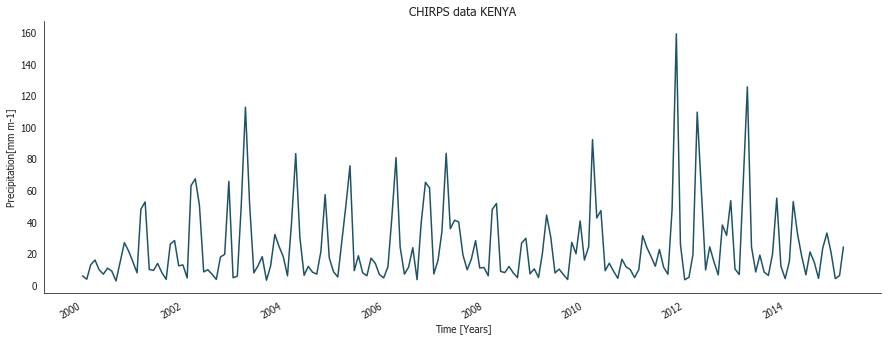

In [9]:
# inputs that are only needed once
extent = (35., 38., 5., 2.)
# loading shapefil into python
fn = r'C:\Users\MPanis\Documents\IARP\Kenya\QGIS\Data\KEN_Admin\ken_admbnda_adm0_iebc_20180607.shp'

names_key = 'ADM0_EN'
abbrev_key = 'ADM0_EN'

# first setup the mask
mask = prepare_mask(fn, names_key, abbrev_key)


var = 'precip'


ds = xr.open_dataset('https://www.oceancolour.org/thredds/dodsC/test/chirps-v2.0.monthly.nc')
m = 1.
if 'latitude' in ds.dims:
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
#dsM = ds.resample(freq = 'M', dim='time', how='mean')
ds_var_KEN_P = cut_xarray(ds, var, extent)

KENYA_P = region_ts_from_ds(ds_var_KEN_P, mask, stepsize=1, return_as_df=False, unit_multiplier=m)

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

KENYA_P.plot()

plt.title('CHIRPS data KENYA')
plt.ylabel('Precipitation[mm m-1]')
plt.xlabel('Time [Years]')

#horizontal line
#plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='')

#vertical bands
#Drought periods Kenya in general
#Desintentar
#ax.axvspan("2009-08-01", "2010-03-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2010-04-01", "2010-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2011-03-01", "2011-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)#duration not known

#EMDAT
#ax.axvspan("2004-07-01", "2005-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2005-12-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2008-07-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2011-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2012-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2014-01-01", "2015-05-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2016-06-01", "2018-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)



Text(0.5, 0, 'Time [Year]')

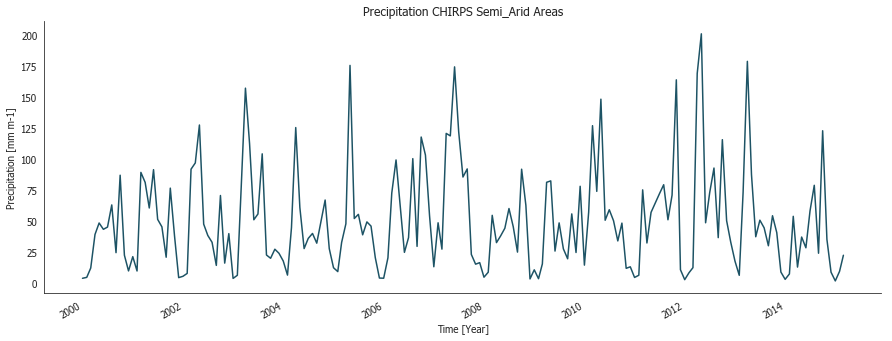

In [10]:
# inputs that are only needed once
extent = (35., 38., 5., 2.)
# loading shapefil into python
fn = r'C:\Users\MPanis\Documents\IARP\Kenya\QGIS\Data\KEN_Semiarid\KEN_Semiaid.shp'

names_key = 'ADM1_EN'
abbrev_key = 'ADM1_EN'

# first setup the mask
mask = prepare_mask(fn, names_key, abbrev_key)

ds = xr.open_dataset('https://www.oceancolour.org/thredds/dodsC/test/chirps-v2.0.monthly.nc')

var = 'precip'
m = 1.

if 'latitude' in ds.dims:
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
#dsM = ds.resample(freq = 'M', dim='time', how='mean')
ds_var_SA_P = cut_xarray(ds, var, extent)

KEN_SA_P = region_ts_from_ds(ds_var_SA_P, mask, stepsize=1, return_as_df=False, unit_multiplier=m)

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

KEN_SA_P.plot()

plt.title('Precipitation CHIRPS Semi_Arid Areas')
plt.ylabel('Precipitation [mm m-1]')
plt.xlabel('Time [Year]')

#plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='')

#Drought periods Kenya in general
#Desintentar
#ax.axvspan("2009-08-01", "2010-03-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2010-04-01", "2010-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2011-03-01", "2011-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)#duration not known

#EMDAT
#ax.axvspan("2004-07-01", "2005-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2005-12-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2008-07-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2011-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2012-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2014-01-01", "2015-05-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2016-06-01", "2018-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)


C:\Users\MPanis\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


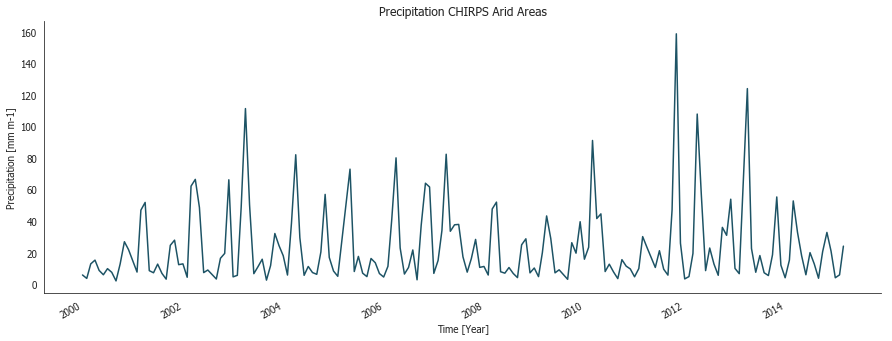

In [11]:
# inputs that are only needed once
extent = (35., 38., 5., 2.)
# loading shapefil into python
fn = r'C:\Users\MPanis\Documents\IARP\Kenya\QGIS\Data\KEN_Arid\KEN_Arid.shp'

names_key = 'ADM1_EN'
abbrev_key = 'ADM1_EN'

# first setup the mask
mask = prepare_mask(fn, names_key, abbrev_key)


ds = xr.open_dataset('https://www.oceancolour.org/thredds/dodsC/test/chirps-v2.0.monthly.nc')

var = 'precip'
m = 1.

if 'latitude' in ds.dims:
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
#dsM = ds.resample(freq = 'M', dim='time', how='mean')
ds_var_A_P = cut_xarray(ds, var, extent)



KEN_A_P = region_ts_from_ds(ds_var_A_P, mask, stepsize=1, return_as_df=False, unit_multiplier=m)


plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
KEN_A_P.plot()

plt.title('Precipitation CHIRPS Arid Areas')
plt.ylabel('Precipitation [mm m-1]')
plt.xlabel('Time [Year]')

#horizontal line
#plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='')

#vertical bands
#Desintentar
#ax.axvspan("2009-08-01", "2010-03-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2010-04-01", "2010-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2011-03-01", "2011-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)#duration not known

#EMDAT
#ax.axvspan("2004-07-01", "2005-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2005-12-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2008-07-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2011-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2012-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2014-01-01", "2015-05-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2016-06-01", "2018-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)


ax = plt.subplot(111)
#Drought periods Kenya in general
#ax.axvspan("2002-02-01", "2002-12-01",  color=sns.xkcd_rgb['grey'], alpha=0.5)

Text(0.5, 1.0, 'Precipitation (CHIRPS) Arid and Semi-Arid areas')

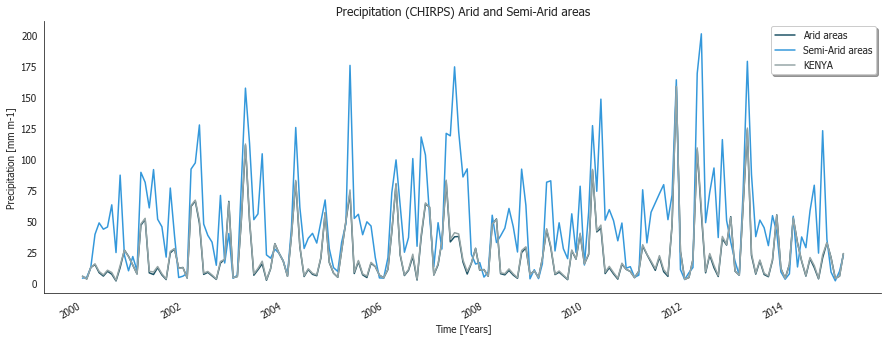

In [12]:
plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Plotted data
KEN_A_P.plot(label='Arid areas')
KEN_SA_P.plot(label='Semi-Arid areas')
KENYA_P.plot(label='KENYA')

#horizontal line
#plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='')

#Layout plot
plt.legend(loc='best',fancybox=True, shadow=True)
plt.ylabel('Precipitation [mm m-1]')
plt.xlabel('Time [Years]')

plt.title('Precipitation (CHIRPS) Arid and Semi-Arid areas')

#vertical bands
#Desintentar
#ax.axvspan("2009-08-01", "2010-03-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2010-04-01", "2010-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)
#ax.axvspan("2011-03-01", "2011-07-31",  color=sns.xkcd_rgb['grey'], alpha=0.5)#duration not known

#EMDAT
#ax.axvspan("2004-07-01", "2005-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2005-12-01", "2006-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2008-07-01", "2009-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2011-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2011-01-01", "2012-12-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2014-01-01", "2015-05-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)
#ax.axvspan("2016-06-01", "2018-01-31",  color=sns.xkcd_rgb['blue'], alpha=0.2)


## Correlation 

In [13]:
a=KEN_A_P.to_dataframe()
b=KEN_SA_P.to_dataframe()
c=KENYA_P.to_dataframe()

a['P A']=a['precip']
a['P SA']=b['precip']
a['P KENYA']=c['precip']

#a['spei A'].corr(a['spei SA'], method='pearson') #or method'spearman'
a.corr(method='pearson') 

,ids,precip,P A,P SA,P KENYA
ids,NaN,NaN,NaN,NaN,NaN
precip,NaN,1.000000,1.000000,0.693545,0.999579
P A,NaN,1.000000,1.000000,0.693545,0.999579
P SA,NaN,0.693545,0.693545,1.000000,0.714161
P KENYA,NaN,0.999579,0.999579,0.714161,1.000000


# Anomaly

In [14]:
def anomaly(time):
    all_avg = KEN_A_P.groupby('time.month').mean(dim='time')
    std = KEN_A_P.std('time')
    
    year = KEN_A_P.sel(time=time)
    year = year.groupby('time.month').mean(dim='time')
    
    anomaly = (year-all_avg) / std
    
    return anomaly

Anomaly = []

for time in range(2000,2016):  
    time=slice(str(time) + '-01-01', str(time) +'-12-31')
    a = anomaly(time)
    Anomaly.append(a)
    
#convert list with seperate arrays to one array
Std_Anomaly = []
for row in Anomaly:
    for obs in row:
        Std_Anomaly.append(np.asarray(obs))
        
#Std_Anomaly.shape
        
Std_Anomaly  = np.asarray(Std_Anomaly )

#np.savetxt(r"C:\Users\MPanis\Documents\510 Documents\Python scripts\CHIRPS_Anomaly.csv", Std_Anomaly , delimiter=",")

C:\Users\MPanis\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


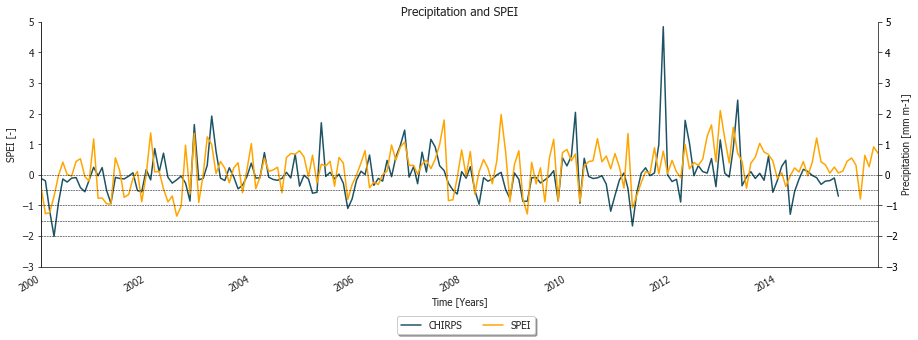

In [15]:
#Read csv file
ds = read_csv(r"C:\Users\MPanis\Documents\510 Documents\Python scripts\Dataset SPEI and CHIRPS.csv", delimiter=',', index_col=None, parse_dates=[0])

#ds.head() used to check which data is in the dataset it precent the top 5 rows
df=ds.set_index('Time', inplace=True)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Plotted data
ds['CHIPRS_ANOMALY'].sort_values(ascending=False).plot(label='CHIRPS')
ax.set_ylabel('SPEI [-]')
ax.set_xlabel('Time [Years]')
ax.set_ylim(-3,5)
#ax.set_title('SPEI and Precipitation Arid Areas')

ax1 = ax.twinx()

ds['SPEI'].sort_values(ascending=False).plot(label='SPEI', color = 'orange')
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)


ax1.set_ylabel('Precipitation [mm m-1]')
ax1.set_title('Precipitation and SPEI')
ax1.set_ylim(-3,5)
for tl in ax1.get_yticklabels():
    tl.set_color('k')
    
fig.legend(loc='best', bbox_to_anchor=(0.5, 0.08),
          ncol=2, fancybox=True, shadow=True)

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='Extremely dry')
plt.axhline(y=-2, color='k', linestyle='--', linewidth=0.5, label='Extremely dry')
plt.axhline(y=-1.5, color='k', linestyle='--', linewidth=0.5, label='Severely dry')
plt.axhline(y=-1.0, color='k', linestyle='--', linewidth=0.5, label='Moderately dry')
plt.axhline(y=-0.5, color='k', linestyle='--', linewidth=0.5, label='Mild dry')

# Climatology

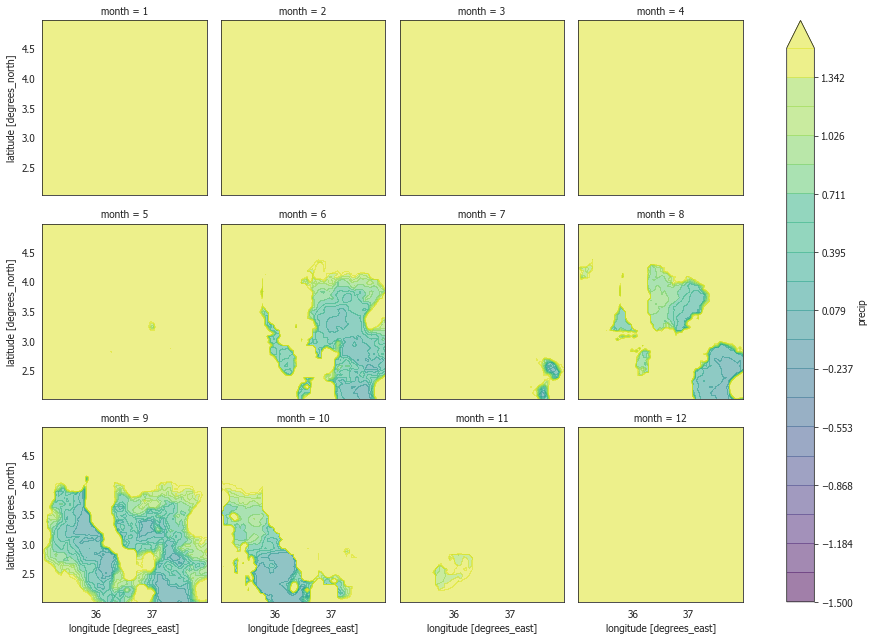

In [16]:
KEN_A_P = ds_var_A_P.groupby('time.month').mean(dim='time')
KEN_A_P_08 = ds_var_A_P.sel(time=slice("2008-01-01", "2008-12-31"))
KEN_A_P_08 = KEN_A_P_08.groupby('time.month').mean(dim='time')

KEN_A_P.plot.contourf(row='month', col_wrap=4, vmin=-1.5, vmax=1.5, alpha=0.5, levels=20)

#Season
#KEN_A_P_season = ds_var_A_P.groupby('time.season').mean(dim='time')
#KEN_A_P_season.plot.contourf(row='season', col_wrap=4, vmin=-1.5, vmax=1.5, alpha=0.5, levels=20)


#spei_monthly['spei'].plot.contourf(row='month', col_wrap=3, vmin=0., vmax=0.3, alpha=0.5, levels=20)

#spei_yearmonthly['spei'].plot.contourf(row='year', col_wrap=3, vmin=0., vmax=0.23, alpha=0.5, levels=20)
#plt.savefig('climatologySM.pdf')

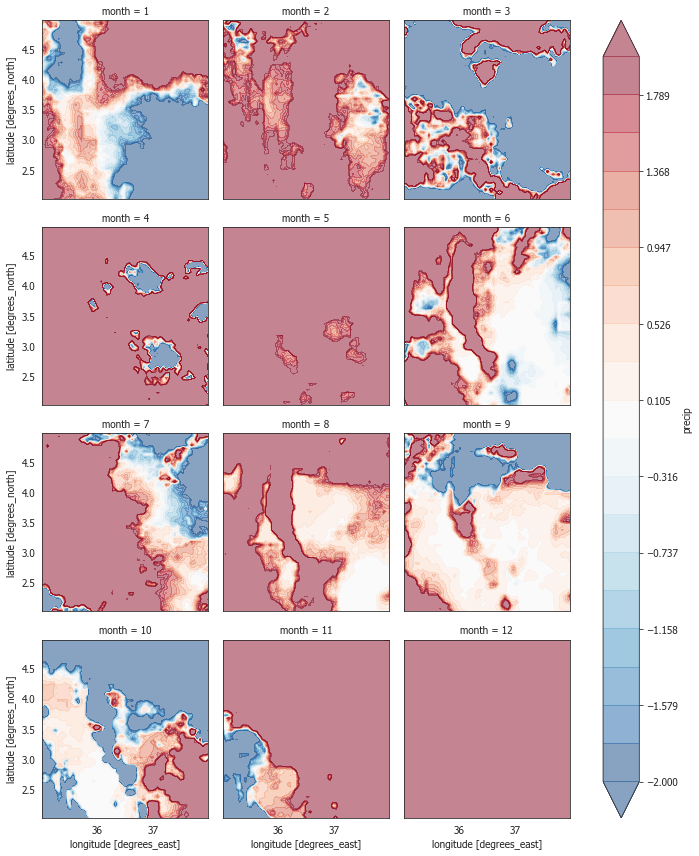

In [17]:
#Anomaly
P_diff = KEN_A_P - KEN_A_P_08

P_diff.plot.contourf(row='month', col_wrap=3, vmin=-2, vmax=2, alpha=0.5, levels=20, cmap='RdBu_r')

## Dry spells

Dry spell occur when there is less than 0.85 mm precipitation in a day. The dataset used in this example is monthly data, which should be daily!

In [18]:
df = read_csv(r"C:\Users\MPanis\Documents\510 Documents\Python scripts\Dataset SPEI and CHIRPS.csv", delimiter=',', index_col=None, parse_dates=[0])

In [19]:
df['dry_spell'] = (df['CHIRPS'] <= (0.85*30)).astype(int)
df['dry_spell_count'] = df.groupby((df['dry_spell'] == 0).cumsum()).cumcount()
df['dry_spell_count'] = df.dry_spell.groupby(df.dry_spell.ne(df.dry_spell.shift()).cumsum()).cumsum()
df['dry_spell_count'] = df['dry_spell_count'].mask(df.dry_spell == 0, 0)

df['dry_spell_cat0'] = (df['dry_spell_count'] < 3).astype(int) 
df['dry_spell_cat0'] = df.dry_spell_cat0.groupby(df.dry_spell_cat0.ne(df.dry_spell_cat0.shift()).cumsum()).cumsum()


df['dry_spell_cat1'] = ((df['dry_spell_count'] >= 3) == (df['dry_spell_count'] < 5)).astype(int) 
df['dry_spell_cat1'] = df.dry_spell_cat1.groupby(df.dry_spell_cat1.ne(df.dry_spell_cat1.shift()).cumsum()).cumsum()

df['dry_spell_cat2'] = ((df['dry_spell_count'] >= 5) == (df['dry_spell_count'] < 10)).astype(int) 
df['dry_spell_cat2'] = df.dry_spell_cat2.groupby(df.dry_spell_cat2.ne(df.dry_spell_cat2.shift()).cumsum()).cumsum()


df['dry_spell_cat3'] = ((df['dry_spell_count'] >= 10)).astype(int) 
df['dry_spell_cat3'] = df.dry_spell_cat3.groupby(df.dry_spell_cat3.ne(df.dry_spell_cat3.shift()).cumsum()).cumsum()

df['dry_spell_cat0_count'] = ((df['dry_spell_cat0'] == 1)).astype(int) 
df['dry_spell_cat1_count'] = ((df['dry_spell_cat1'] == 1)).astype(int) 
df['dry_spell_cat2_count'] = ((df['dry_spell_cat2'] == 1)).astype(int) 
df['dry_spell_cat3_count'] = ((df['dry_spell_cat3'] == 1)).astype(int) 

df

,Time,CHIRPS,CHIPRS_ANOMALY,SPEI,dry_spell,dry_spell_count,dry_spell_cat0,dry_spell_cat1,dry_spell_cat2,dry_spell_cat3,dry_spell_cat0_count,dry_spell_cat1_count,dry_spell_cat2_count,dry_spell_cat3_count
0,2000-01-01,5.92,-0.1170,-0.37800,1,1,1,0,0,0,1,0,0,0
1,2000-02-01,3.73,-0.1960,-1.27000,1,2,2,0,0,0,0,0,0,0
2,2000-03-01,12.90,-1.1600,-1.24000,1,3,0,1,0,0,0,1,0,0
3,2000-04-01,15.30,-2.0100,-0.70100,1,4,0,2,0,0,0,0,0,0
4,2000-05-01,8.80,-0.9280,-0.04070,1,5,0,0,1,0,0,0,1,0
5,2000-06-01,6.05,-0.1370,0.41600,1,6,0,0,2,0,0,0,0,0
6,2000-07-01,9.92,-0.2370,0.00979,1,7,0,0,3,0,0,0,0,0
7,2000-08-01,7.59,-0.1090,-0.04380,1,8,0,0,4,0,0,0,0,0
8,2000-09-01,2.15,-0.0897,0.43500,1,9,0,0,5,0,0,0,0,0
9,2000-10-01,12.90,-0.4170,0.52600,1,10,0,0,0,1,0,0,0,1


In [20]:
#df.groupby(pd.Grouper(key = 'time', freq = 'M'))['dry_spell_cat0'].sum()
#df['rolling'] = df['dry_spell_3threshold'].rolling(window=31).sum()

#df.groupby(pd.Grouper(key = 'time', freq = 'M'))['rolling'].sum()

### Save files as netcdf, csv or figure

In [21]:
#save data to netcdf
path = r'C:\....\....\....nc'
df=df_region_month

df.to_netcdf(path=path, mode='w', format=None, group=None, engine=None, encoding=None, unlimited_dims=None)

df=df.to_dataframe()

#save as CSV
df.to_csv('C:\.....\....\.....csv', index = True, sep=',', encoding='utf-8', date_format=None, header=True)

#save plot as figure
fig.savefig(r'C:\\\name.png', bbox_inches='tight',pad_inches=0.1)

NameError: name 'df_region_month' is not defined

### Basic reminders and examples pieces of scripts

In [ ]:
#variables within netcdf
ds.variables.keys()

#remove a specific value != or <, > etc.
ds_masked = ds.where(ds['SM_C1N'] != -2.)  #removing -2 values representing open water

#identify variables, unites and shape of dataset
for i in Rainfall.variables:
    print(i, Rainfall.variables[i].units, Rainfall.variables[i].shape)
    
    
#making boxplots 
ax = sns.boxplot(data = a, x='Month',y='Rainf')

#Pairplot
sns.pairplot(a)

#select specific location over specific time
ds_loc = ds.sel(lon=..... , lat=...., method='nearest')
ds_time = ds_loc.sel(time=slice("2001-01-01", "2012-11-01"))

#Look for data smaller than -0.8 within dataset

b = a['spi3'][a['spi3'] <= -0.8]  

#identify certain value within dataset
colnames = ['spi3', 'spi6', 'spi12']

def drought(colnames, droughtValue):
    interceptData = {}
    a = spi_avg_1.to_dataframe()
    for names in colnames:
        droughtData = pd.DataFrame(a[names][a[names] <= droughtValue])
        interceptData[names] = droughtData
    return(interceptData)

data_drought = drought(colnames, -0.5)
data_drought['spi3']